# DKL with custom CNN
Inputs -  ICCD images;
Outputs - score (Raman peak prominence)


Ganesh Narasimha

# Imports

In [1]:
import matplotlib.pylab as plt
import numpy as np

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset



In [2]:
# Import GP and BoTorch functions
import gpytorch as gpt
import pandas as pd
from botorch.models import SingleTaskGP, ModelListGP

#from botorch.models import gpytorch
# from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel, PeriodicKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan
from gpytorch.models import ExactGP
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from smt.sampling_methods import LHS
from torch.optim import SGD
from torch.optim import Adam
from scipy.stats import norm


In [3]:

from GP_functions import *
from custom_models import *
from ICCD_Dataset import *
from Plot_DKL_predictions import *


# Functions

In [4]:

def norm_0to1_tensor(X):

    norm_tensor = torch.empty_like(X)

    for i in range(X.shape[-1]):
        torch_i = X[:, i]
        norm_i = (torch_i - torch.min(torch_i))/(torch.max(torch_i) - torch.min(torch_i))
        norm_tensor[:, i] = norm_i
           
    return norm_tensor

def extract_data(dataloader, norm = True):
    images = []
    params =[]
    scores = []
    indices = []

    for i, (images_i, params_i, score_i) in enumerate(dataloader):

        images.append(images_i)
        params.append(params_i)
        scores.append(score_i)

        indices.append(i)

    

    images = torch.cat(images, axis=0)
    params = torch.cat(params, axis=0)
    scores = torch.cat(scores, axis=0)
    indices = np.array(indices)
    

    if norm:
        params = norm_0to1_tensor(params)
        scores = norm_0to1_tensor(scores)

    return images, params, scores, indices


def append_to_train(X, y, X_train, y_train, train_indices, ind):
    X_train = torch.cat((X_train, X[ind:ind+1]), axis=0)
    y_train = torch.cat((y_train, y[ind:ind+1]), axis=0)
    train_indices = np.hstack((train_indices, ind))

    return X_train, y_train, train_indices

# Get dataset

In [5]:
datafile = 'data/PLD data.json'

# Get the raw dataset, wo transforms
dataset1 = ICCDDataset(datafile)


# Define the transform1
transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
# Define the dataset with the transform
dataset2 = ICCDDataset(datafile, transform = transform)


# Define the transform with Gaussian noise
transform_with_noise = transforms.Compose([
    transforms.RandomAffine(180, translate=(0.1, 0.1), shear=10, scale=(0.8, 1.2)),
    AddGaussianNoise(mean=0.0, std=0.1)
])

# Define the noise for parameters
param_noise = AddGaussianNoise(mean=0.0, std=0.1)

# Define the dataset with the transform and noise
dataset3 = ICCDDataset(datafile, transform=transform_with_noise, params_noise=param_noise)


# Combine the datsets
dataset = ConcatDataset([dataset1, dataset2, dataset3])



In [6]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

X, orig_params, score, _ = extract_data(dataloader, norm = False)

X, params, y, indices = extract_data(dataloader)




In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.2, random_state=24)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)

torch.Size([304, 1, 50, 40, 40]) torch.Size([304, 1]) torch.Size([77, 1, 50, 40, 40]) torch.Size([77, 1])


# DKL with Custom_nn

## Single step training

In [8]:
from custom_models import DKL_Custom_nn, MLP, ICCDNet

In [9]:
custom_nn = ICCDNet(output_dim = 3)

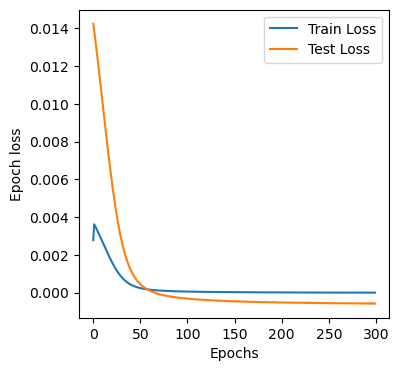

Training_loss:  -2.8318677450983055e-06


In [11]:
model, training_loss, testing_loss = train_test_custom_nn_DKL(train_dataset, test_dataset, custom_nn, num_epochs = 300, plot_loss = True, n_batches = 1)
print("Training_loss: ",training_loss[-1])

In [12]:
y_means, y_vars = DKL_posterior(model, X)
y_means.shape, y_vars.shape


(torch.Size([381, 1]), torch.Size([381, 1]))

In [13]:
acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y)
ind = np.random.choice(acq_ind)

print(ind)

147


## Active learning

Here we choose a smaller training set

In [12]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.9, random_state=24)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)

torch.Size([38, 1, 50, 40, 40]) torch.Size([38, 1]) torch.Size([343, 1, 50, 40, 40]) torch.Size([343, 1])


In [13]:
#Set the number of exploration steps
exploration_steps = 30
beta = 1

for i in range(exploration_steps):

    print(f"\n------------------Exploration Step:{i+1} ----------------------- ")
    custom_nn = ICCDNet(output_dim = 3)

    device  = "cuda" if torch.cuda.is_available() else 'cpu'

    # Contruct the GP surrogate function
    model, training_loss = train_custom_nn_DKL(train_dataset, custom_nn, num_epochs = 200, device= device)
    print("training_loss", training_loss[-1])

    # Calculate the predicted posterior mean and variance
    y_means, y_vars = DKL_posterior(model, X)

    # Calculate the acquisition function using E!
    #acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y, index_exclude= train_indices)
    
    #UCB acquisition funtion
    beta = 0.9*beta #beta decay
    acq_ind, acq_val_max, Acq_vals = acq_fn_UCB(y_means, y_vars, beta = beta, index_exclude= train_indices)

    # best estimates
    #X_best_train, X_best_pred = best_mean_estimate(train_X, train_y, X, y_means)

    ind = np.random.choice(acq_ind)
   

    #Next measurement point
    #next_X = X[ind,:]
    next_score = score[ind,:]
    
    # #Plot the results
    # plot_results(X_train, y_train, X, y_means, y_vars, Acq_vals, X_best_train, ind)

    #Print the results
    #print("Next Acquisition at: ", next_X)
    print("Next-index: ",ind)
    print("Measured score: ", next_score)
   

    #Update training data
    train_X, train_y, train_indices = append_to_train(X, y, train_X, train_y, train_indices, ind)
    


------------------Exploration Step:1 ----------------------- 


training_loss 0.2125134391011572
Next-index:  240
Measured score:  tensor([65.3230])

------------------Exploration Step:2 ----------------------- 


training_loss -0.0044587074677092265
Next-index:  180
Measured score:  tensor([6.6001])

------------------Exploration Step:3 ----------------------- 


training_loss -0.015899239836014108
Next-index:  323
Measured score:  tensor([0.5432])

------------------Exploration Step:4 ----------------------- 


training_loss 0.001956504280583563
Next-index:  149
Measured score:  tensor([1.6872])

------------------Exploration Step:5 ----------------------- 


training_loss -0.017743680169308343
Next-index:  204
Measured score:  tensor([0.4545])

------------------Exploration Step:6 ----------------------- 


training_loss -0.01707626753706054
Next-index:  136
Measured score:  tensor([147.0493])

------------------Exploration Step:7 ----------------------- 


training_loss 0.0017929792485184741
Next-index:  165
Measured score:  tensor([28.9154])

------------------Exploration Step:8 ----------------------- 


training_loss -0.019038732884066836
Next-index:  367
Measured score:  tensor([65.3230])

------------------Exploration Step:9 ----------------------- 


training_loss 0.009250715468503506
Next-index:  146
Measured score:  tensor([1.6521])

------------------Exploration Step:10 ----------------------- 


training_loss -0.009722745818252514
Next-index:  273
Measured score:  tensor([1.6521])

------------------Exploration Step:11 ----------------------- 


training_loss 0.015817907716247276
Next-index:  183
Measured score:  tensor([0.2487])

------------------Exploration Step:12 ----------------------- 


training_loss -0.007194157078536125
Next-index:  309
Measured score:  tensor([0.3776])

------------------Exploration Step:13 ----------------------- 


training_loss 0.08324786922360887
Next-index:  242
Measured score:  tensor([24.4115])

------------------Exploration Step:14 ----------------------- 


training_loss 0.008634519562740278
Next-index:  114
Measured score:  tensor([1.9399])

------------------Exploration Step:15 ----------------------- 


training_loss 0.0328216866495087
Next-index:  373
Measured score:  tensor([17.6336])

------------------Exploration Step:16 ----------------------- 


training_loss 0.21100649243917163
Next-index:  269
Measured score:  tensor([0.])

------------------Exploration Step:17 ----------------------- 


training_loss -0.005359497531083745
Next-index:  258
Measured score:  tensor([282.4994])

------------------Exploration Step:18 ----------------------- 


training_loss 0.2551145181478147
Next-index:  324
Measured score:  tensor([1.0331])

------------------Exploration Step:19 ----------------------- 


training_loss 0.009773940262907472
Next-index:  299
Measured score:  tensor([39.9821])

------------------Exploration Step:20 ----------------------- 


training_loss 0.002459041213296323
Next-index:  327
Measured score:  tensor([64.9705])

------------------Exploration Step:21 ----------------------- 


training_loss 0.21564331769344994
Next-index:  212
Measured score:  tensor([0.0676])

------------------Exploration Step:22 ----------------------- 


training_loss 0.013957910201171724
Next-index:  158
Measured score:  tensor([0.5197])

------------------Exploration Step:23 ----------------------- 


training_loss 0.0205860435808981
Next-index:  205
Measured score:  tensor([1.0297])

------------------Exploration Step:24 ----------------------- 


training_loss -0.011574245178649467
Next-index:  196
Measured score:  tensor([0.5432])

------------------Exploration Step:25 ----------------------- 


training_loss 0.012675206552448727
Next-index:  226
Measured score:  tensor([0.7824])

------------------Exploration Step:26 ----------------------- 


training_loss 0.0021797512188063946
Next-index:  266
Measured score:  tensor([57.7010])

------------------Exploration Step:27 ----------------------- 


training_loss 0.016570137928770608
Next-index:  40
Measured score:  tensor([491.2806])

------------------Exploration Step:28 ----------------------- 


training_loss -0.019705017716149888
Next-index:  307
Measured score:  tensor([6.6001])

------------------Exploration Step:29 ----------------------- 


training_loss -0.014950990939125488
Next-index:  306
Measured score:  tensor([347.1290])

------------------Exploration Step:30 ----------------------- 


training_loss -0.01991428423972221
Next-index:  99
Measured score:  tensor([0.7824])


## Results

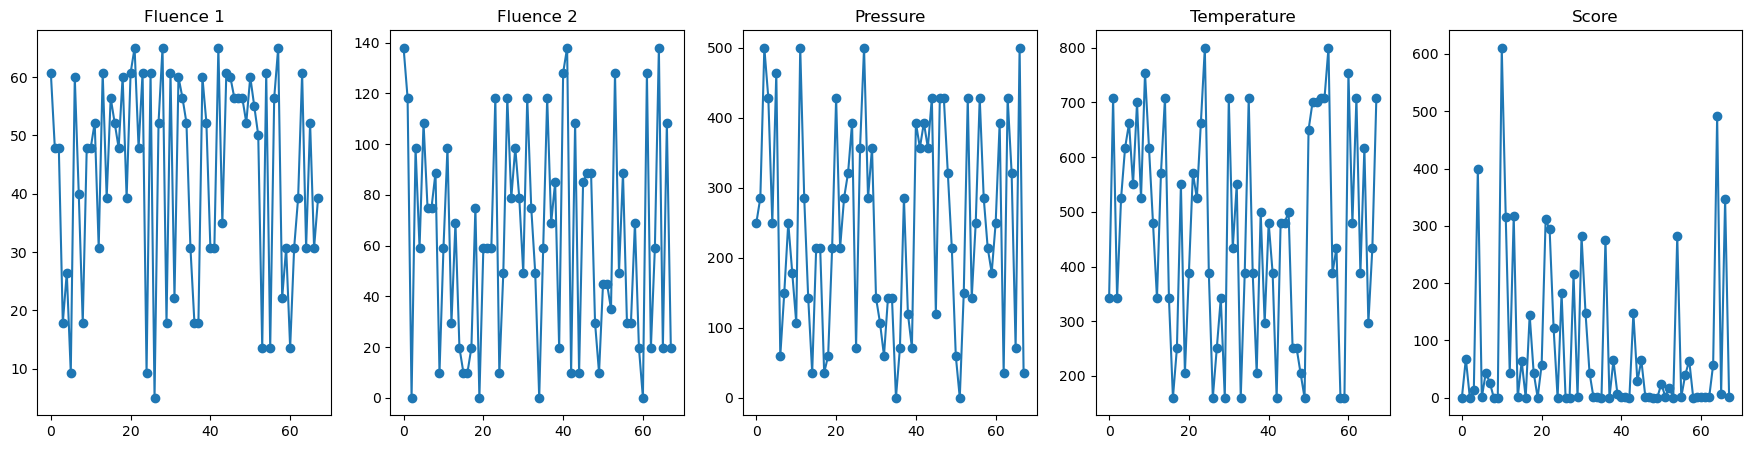

In [14]:
plot_train_series(train_indices, orig_params, score)

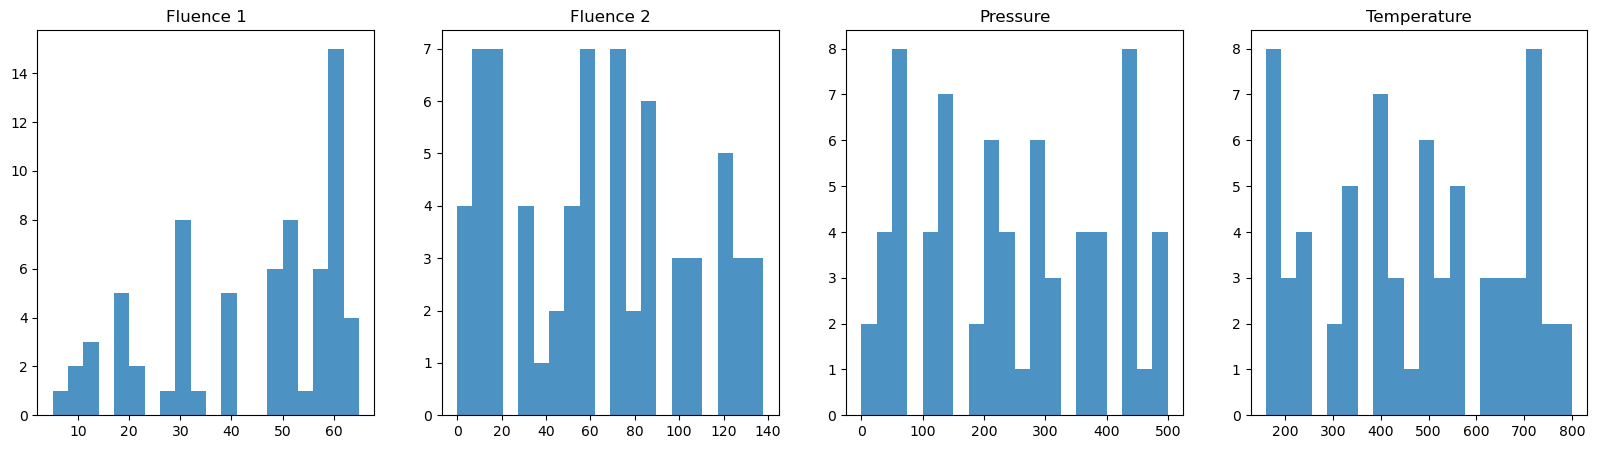

In [15]:
plot_train_hist(train_indices, orig_params)

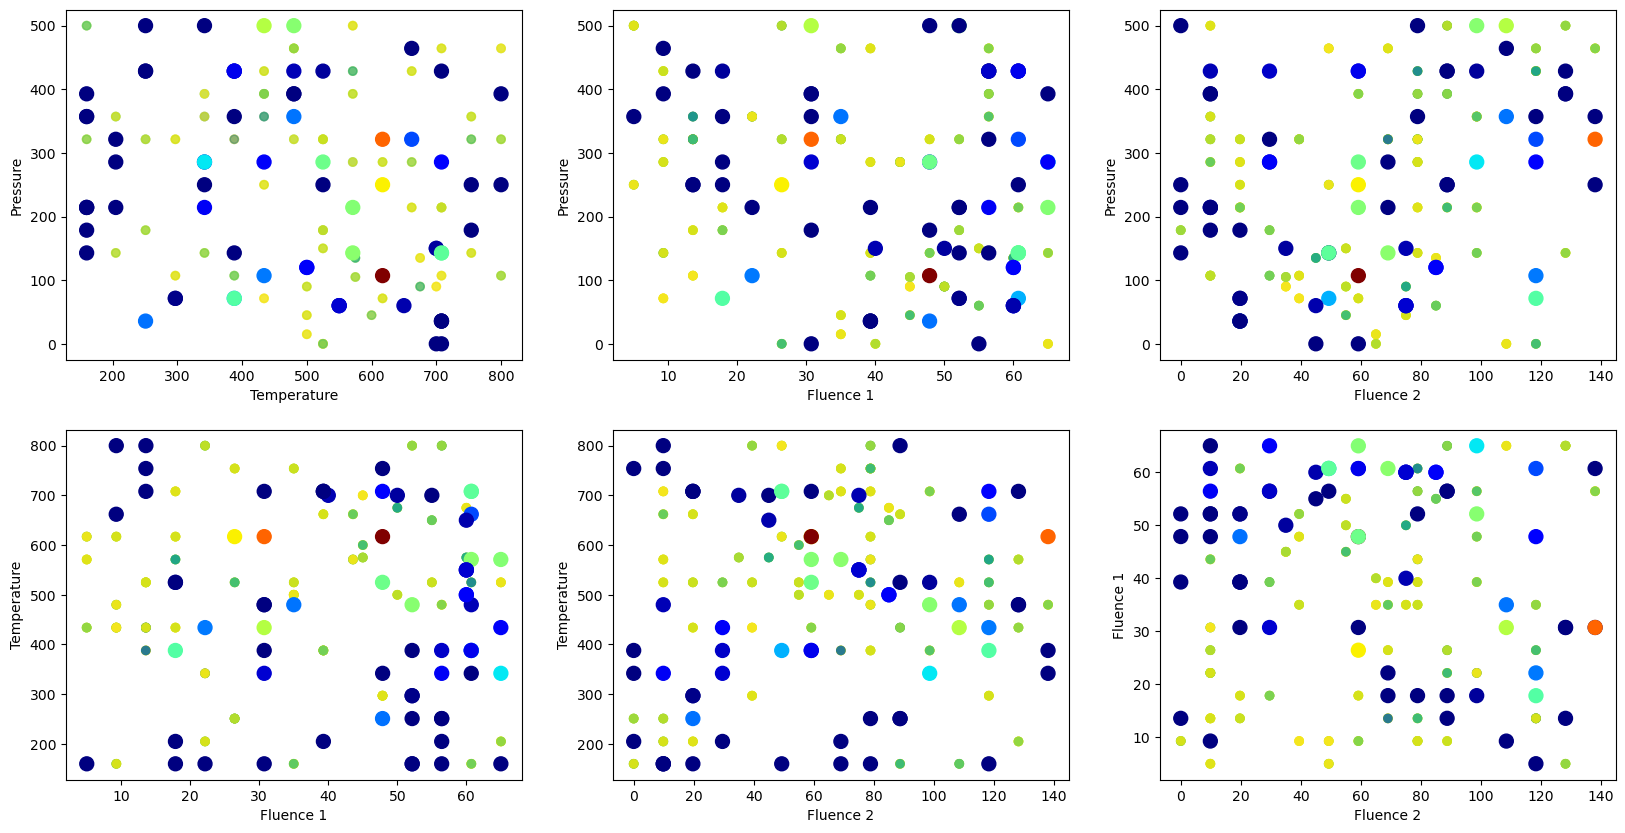

In [16]:
plot_mean_map(y_means, train_indices, orig_params, score)

Independly, use the DKL sampled points to map the params to the score using an independent GP regression

training_loss 0.00028496216434766264


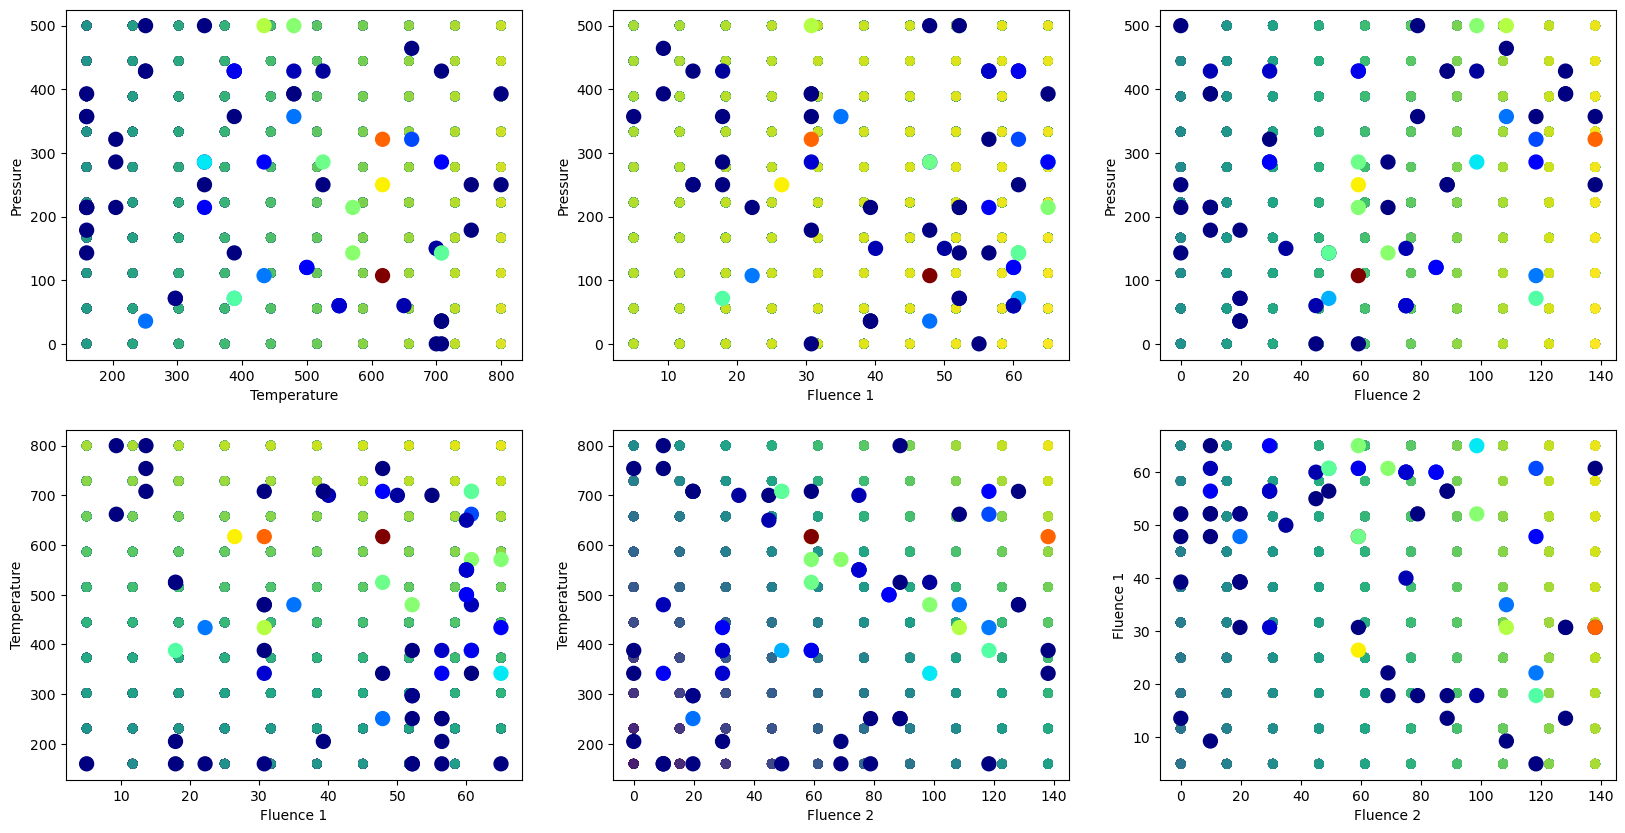

In [17]:
train_params = params[train_indices]

# predict GP map across the parameter space
y_GPmean, _, _ = parameter_mapping(train_params, train_y, orig_params, param_divs = [10, 10, 10, 10], plot_GP = True, num_epochs = 200)



# DKL with RCNN

In [18]:

datafile = 'data/PLD data.json'

# Get the dataset, for RCNN, the images_sequence is shaped as: (batch_size=127, seq_len=50, classes =1, width=40, height=40)
dataset1 = ICCDDataset(datafile, image_for_rcnn = True)


# Define the transform1
transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
# Define the dataset with the transform
dataset2 = ICCDDataset(datafile, transform = transform, image_for_rcnn = True)


# Define the transform with Gaussian noise
transform_with_noise = transforms.Compose([
    transforms.RandomAffine(180, translate=(0.1, 0.1), shear=10, scale=(0.8, 1.2)),
    AddGaussianNoise(mean=0.0, std=0.1)
])

# Define the noise for parameters
param_noise = AddGaussianNoise(mean=0.0, std=0.1)

# Define the dataset with the transform and noise
dataset3 = ICCDDataset(datafile, transform=transform_with_noise, params_noise=param_noise, image_for_rcnn = True)


# Combine the datsets
dataset = ConcatDataset([dataset1, dataset2, dataset3])



In [19]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
X, orig_params, score,_ = extract_data(dataloader, norm = False)
X, params, y, indices = extract_data(dataloader)

In [20]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.2, random_state=24)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)

torch.Size([304, 50, 1, 40, 40]) torch.Size([304, 1]) torch.Size([77, 50, 1, 40, 40]) torch.Size([77, 1])


# Single step training

In [21]:
from custom_models import RCNN_FeatureExtractor

In [22]:
custom_nn = RCNN_FeatureExtractor(output_dim = 3)

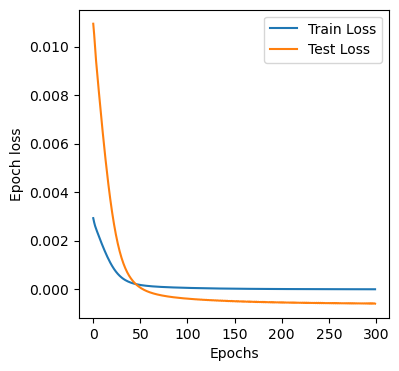

training_loss -6.3577035989438825e-06
Test loss -0.000598988439939835


In [23]:
model, training_loss, test_loss = train_test_custom_nn_DKL(train_dataset,test_dataset, custom_nn, num_epochs = 300, plot_loss = True, n_batches = 1)
print("training_loss", training_loss[-1])
print("Test loss", test_loss[-1])

In [24]:
y_means, y_vars = DKL_posterior(model, X)
y_means.shape, y_vars.shape


(torch.Size([381, 1]), torch.Size([381, 1]))

In [25]:
acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y)
ind = np.random.choice(acq_ind)

print(ind)

143


## Active Learning

In [26]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.9, random_state=24)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)

torch.Size([38, 50, 1, 40, 40]) torch.Size([38, 1]) torch.Size([343, 50, 1, 40, 40]) torch.Size([343, 1])


In [27]:
#Set the number of exploration steps
exploration_steps = 30

for i in range(exploration_steps):

    print(f"\n------------------Exploration Step:{i+1} ----------------------- ")
    custom_nn = RCNN_FeatureExtractor(output_dim = 3)

    device  = "cuda" if torch.cuda.is_available() else 'cpu'

    # Contruct the GP surrogate function
    model, training_loss = train_custom_nn_DKL(train_dataset, custom_nn, num_epochs = 200, device= device)
    print("training_loss", training_loss[-1])

    # Calculate the predicted posterior mean and variance
    y_means, y_vars = DKL_posterior(model, X)

    # Calculate the acquisition function
    acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y, index_exclude= train_indices)


    # best estimates
    #X_best_train, X_best_pred = best_mean_estimate(train_X, train_y, X, y_means)

    ind = np.random.choice(acq_ind)
   

    #Next measurement point
    #next_X = X[ind,:]
    next_score = score[ind,:]
    
    # #Plot the results
    # plot_results(X_train, y_train, X, y_means, y_vars, Acq_vals, X_best_train, ind)

    #Print the results
    #print("Next Acquisition at: ", next_X)
    print("Next-index: ",ind)
    print("Measured score: ", next_score)
   

    #Update training data
    train_X, train_y, train_indices = append_to_train(X, y, train_X, train_y, train_indices, ind)


------------------Exploration Step:1 ----------------------- 


training_loss -0.002428152718010202
Next-index:  316
Measured score:  tensor([0.5748])

------------------Exploration Step:2 ----------------------- 


training_loss 0.011750576431790694
Next-index:  119
Measured score:  tensor([17.6336])

------------------Exploration Step:3 ----------------------- 


training_loss -0.01188855694821997
Next-index:  374
Measured score:  tensor([6.6775])

------------------Exploration Step:4 ----------------------- 


training_loss 0.005468318828501511
Next-index:  265
Measured score:  tensor([5.0776])

------------------Exploration Step:5 ----------------------- 


training_loss 0.010629263892740218
Next-index:  138
Measured score:  tensor([5.0776])

------------------Exploration Step:6 ----------------------- 


training_loss 0.017421087629697143
Next-index:  146
Measured score:  tensor([1.6521])

------------------Exploration Step:7 ----------------------- 


training_loss -0.017034382425324596
Next-index:  34
Measured score:  tensor([0.4872])

------------------Exploration Step:8 ----------------------- 


training_loss 0.2133053628960522
Next-index:  79
Measured score:  tensor([81.0307])

------------------Exploration Step:9 ----------------------- 


training_loss 0.02601954893633485
Next-index:  113
Measured score:  tensor([65.3230])

------------------Exploration Step:10 ----------------------- 


training_loss 0.021890009811620863
Next-index:  324
Measured score:  tensor([1.0331])

------------------Exploration Step:11 ----------------------- 


training_loss -0.008870923999778155
Next-index:  365
Measured score:  tensor([96.7123])

------------------Exploration Step:12 ----------------------- 


training_loss -0.015582318109694564
Next-index:  314
Measured score:  tensor([144.2555])

------------------Exploration Step:13 ----------------------- 


training_loss -0.010129520487319639
Next-index:  148
Measured score:  tensor([0.5292])

------------------Exploration Step:14 ----------------------- 


training_loss -0.0091534162900052
Next-index:  348
Measured score:  tensor([0.6065])

------------------Exploration Step:15 ----------------------- 


training_loss 0.018013421748146005
Next-index:  249
Measured score:  tensor([3.0577])

------------------Exploration Step:16 ----------------------- 


training_loss 0.030817402178742504
Next-index:  237
Measured score:  tensor([137.0180])

------------------Exploration Step:17 ----------------------- 


training_loss 0.013437454544509335
Next-index:  158
Measured score:  tensor([0.5197])

------------------Exploration Step:18 ----------------------- 


training_loss 0.019069798849472554
Next-index:  178
Measured score:  tensor([0.5596])

------------------Exploration Step:19 ----------------------- 


training_loss 0.00821040368811567
Next-index:  295
Measured score:  tensor([5.4564])

------------------Exploration Step:20 ----------------------- 


training_loss -0.014612904987918666
Next-index:  27
Measured score:  tensor([455.6251])

------------------Exploration Step:21 ----------------------- 


training_loss 0.004525863793726267
Next-index:  351
Measured score:  tensor([0.4913])

------------------Exploration Step:22 ----------------------- 


training_loss 0.22647921162270454
Next-index:  30
Measured score:  tensor([298.0524])

------------------Exploration Step:23 ----------------------- 


training_loss 0.005227686584781423
Next-index:  229
Measured score:  tensor([0.5300])

------------------Exploration Step:24 ----------------------- 


training_loss 0.003378116146080798
Next-index:  317
Measured score:  tensor([0.2468])

------------------Exploration Step:25 ----------------------- 


training_loss 0.0076386889514637206
Next-index:  17
Measured score:  tensor([0.])

------------------Exploration Step:26 ----------------------- 


training_loss 0.022672929557520424
Next-index:  341
Measured score:  tensor([2.0384])

------------------Exploration Step:27 ----------------------- 


training_loss 0.021416092765601077
Next-index:  247
Measured score:  tensor([6.6775])

------------------Exploration Step:28 ----------------------- 


training_loss -0.00270070380399968
Next-index:  26
Measured score:  tensor([4.0239])

------------------Exploration Step:29 ----------------------- 


training_loss -0.017973194880527045
Next-index:  165
Measured score:  tensor([28.9154])

------------------Exploration Step:30 ----------------------- 


training_loss -0.003213029823219443
Next-index:  275
Measured score:  tensor([0.5292])


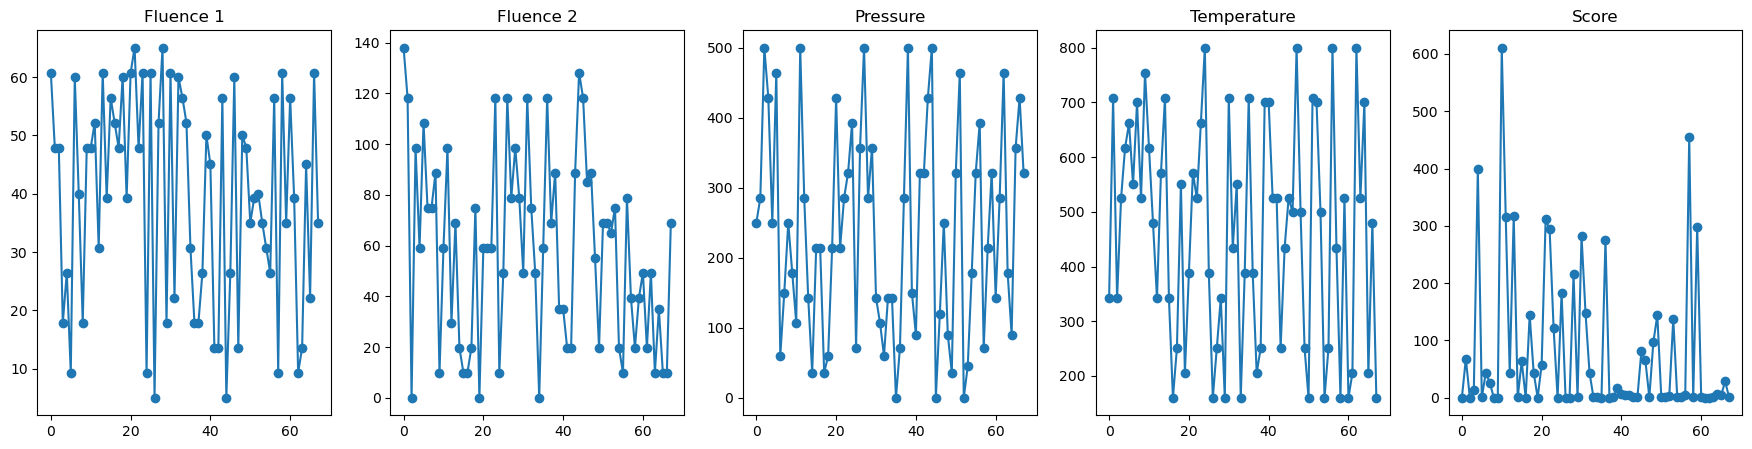

In [28]:
plot_train_series(train_indices, orig_params, score)

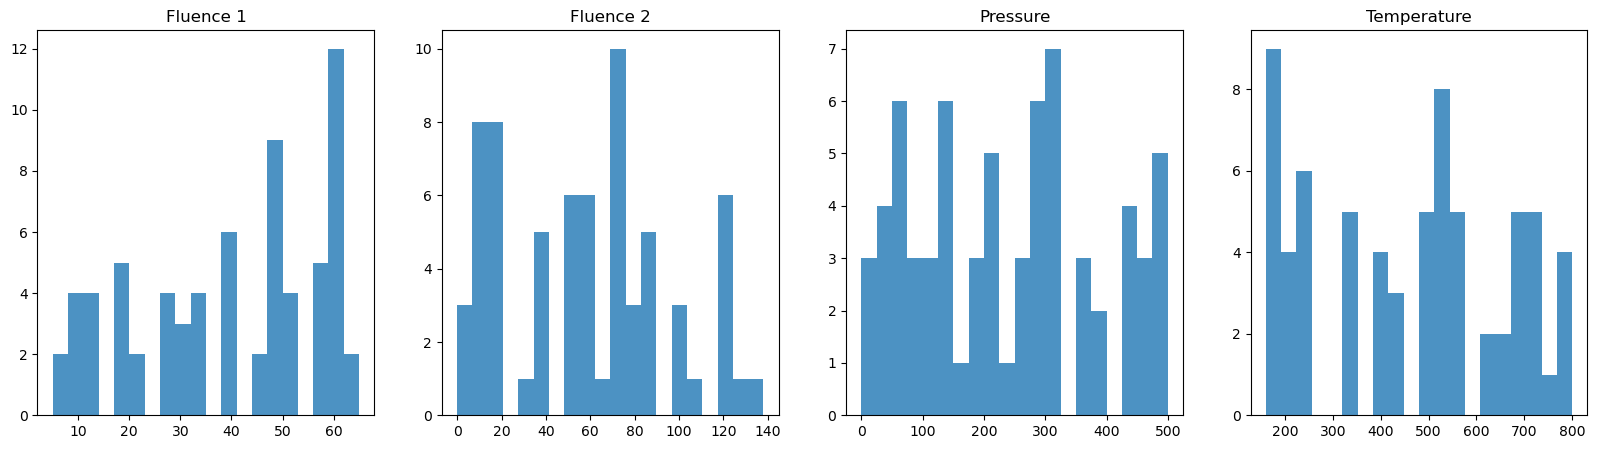

In [29]:
plot_train_hist(train_indices, orig_params)

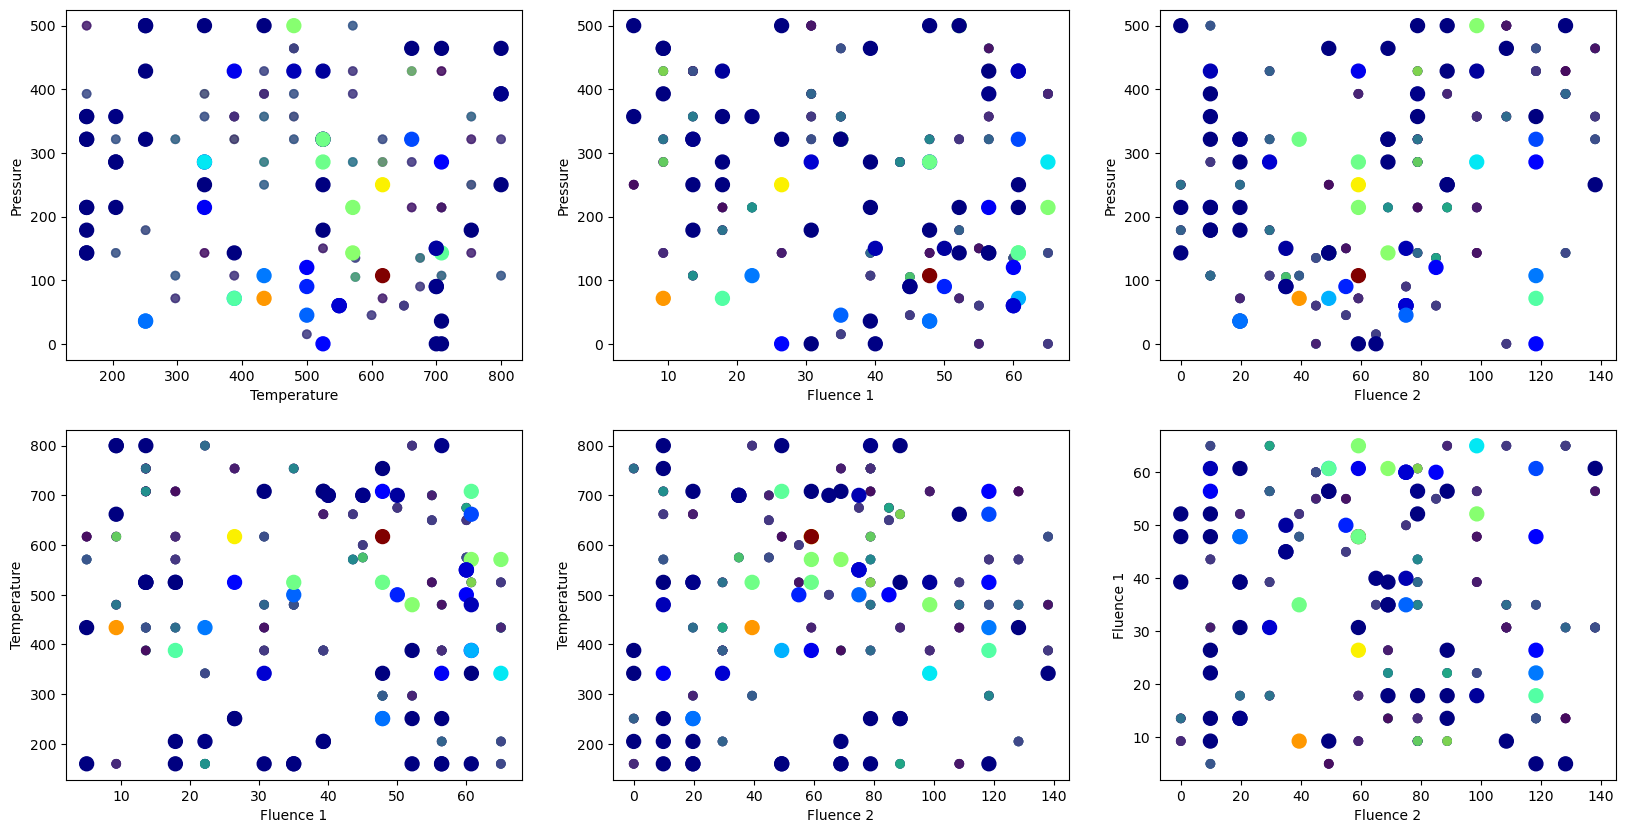

In [30]:
plot_mean_map(y_means, train_indices, orig_params, score)

Independly, use the DKL sampled points to map the params to the score using an independent GP regression

training_loss 0.001399127656922621


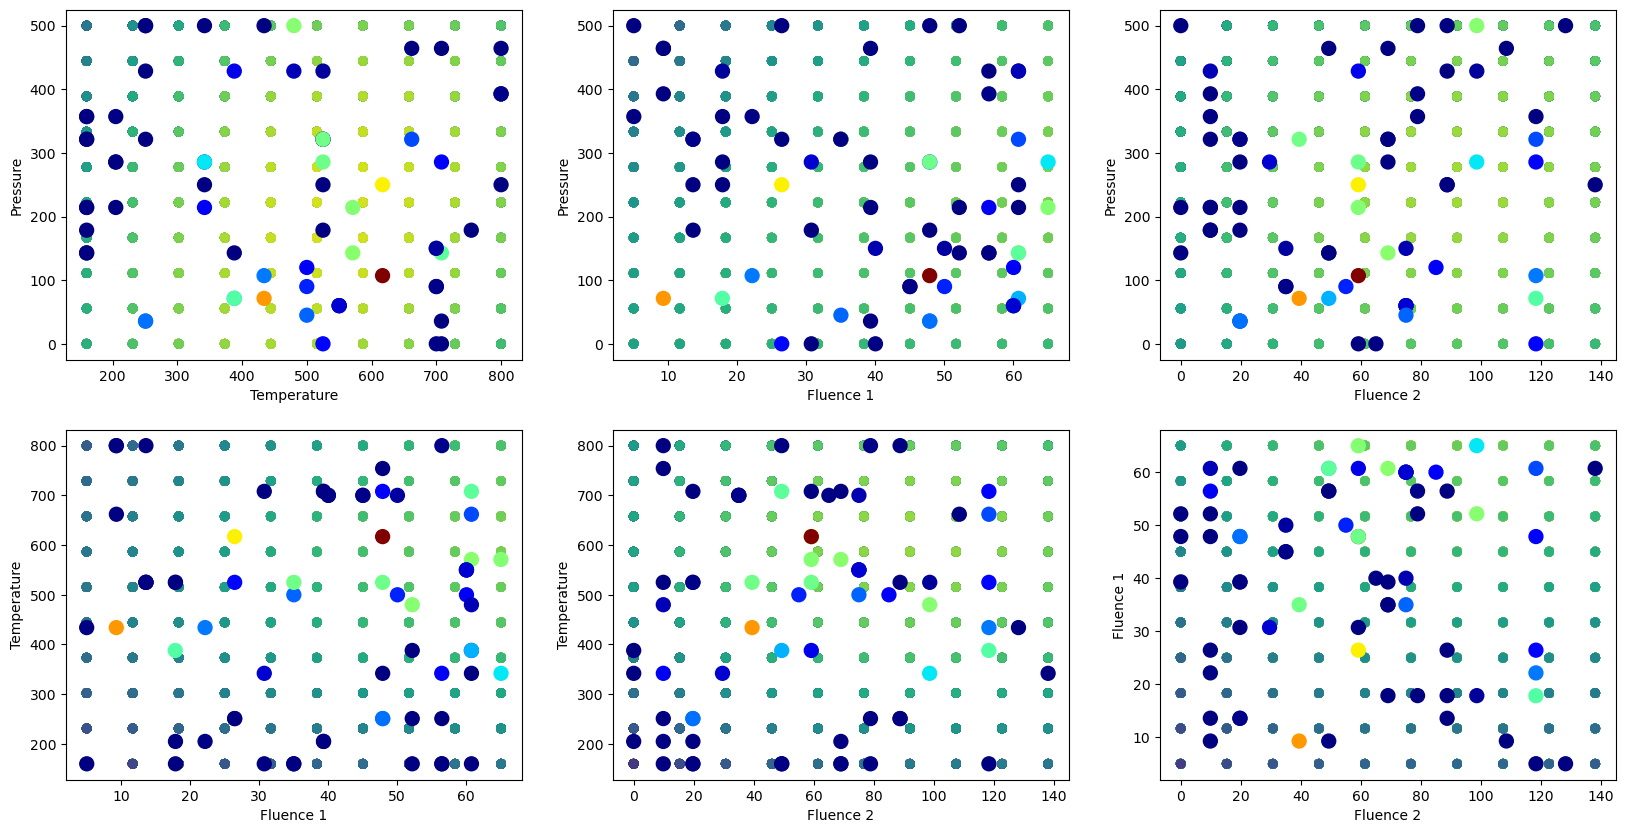

In [31]:
train_params = params[train_indices]

y_GPmean, _, _ = parameter_mapping(train_params, train_y, orig_params, param_divs = [10, 10, 10, 10], plot_GP = True)
